In [1]:
import os
import sys
from glob import glob
from itertools import combinations, permutations
from textwrap import wrap

import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from Timer import timer
from scipy import stats
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import roc_auc_score, pairwise_distances
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tabulate import tabulate
from tqdm import tqdm
from multiprocessing import Pool
from collections import namedtuple
from itertools import combinations

# from utility_functions import add_topic_to_qdf, ensure_file

# from qpptk import Config, ensure_file, add_topic_to_qdf, ensure_dir, overlap_coefficient
# from qpptk.global_manager import initialize_text_queries, initialize_ciff_queries

In [2]:
RANDOM_SEED = 1609

In [3]:
def ensure_file(file):
    """Ensure a single file exists, returns the absolute path of the file if True or raises FileNotFoundError if not"""
    # tilde expansion
    file_path = os.path.normpath(os.path.expanduser(file))
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} doesn't exist")
    return file_path

In [4]:
with open('/research/local/oleg/qpptk_irj/qpptk-ecir_21/duplicated_qids.txt') as f:
    DUPLICATED_QIDS = {line.rstrip('\n') for line in f}

In [5]:
# prefix_path = './data/robust_krovetz_nostop_terrier'
prefix_path = './robust04_Lucene_indri_porter'
ir_metric = 'ap@1000'

In [6]:
post_predictors = dict(wig = './robust04_Lucene_indri_porter_QL_wig+10.pre',
nqc = './robust04_Lucene_indri_porter_QL_nqc+100.pre',
smv = './robust04_Lucene_indri_porter_QL_smv+100.pre',
clarity = './robust04_Lucene_indri_porter_QL_clarity+1000.pre',
uef_wig = './robust04_Lucene_indri_porter_QL_uef+1000+100-wig+10.pre',
uef_nqc = './robust04_Lucene_indri_porter_QL_uef+1000+100-nqc+100.pre',
uef_smv = './robust04_Lucene_indri_porter_QL_uef+1000+100-smv+100.pre',
uef_clarity = './robust04_Lucene_indri_porter_QL_uef+1000+100-clarity+1000.pre')


In [7]:
r_type = 'all'
if r_type == 'all':
    post_ret_predictors = list(post_predictors.values())
    pre_ret_predictors = glob(prefix_path + '*PRE*')
    predictors = pre_ret_predictors + post_ret_predictors
elif r_type.lower() == 'pre':
    predictors = glob(prefix_path + '*PRE*')
else:
    predictors = glob(prefix_path + '_QL*.pre')
_results = []
for _file in predictors:
    collection, method, predictor = _file.rsplit('/', 1)[1].replace('.pre', '').rsplit('_', 2)
    predictor = ''.join([i for i in predictor if not i.isdigit()]).replace('+', '')
    _results.append(
        pd.read_csv(_file, delim_whitespace=True, names=['topic', 'qid', predictor], index_col=['topic', 'qid']))
all_predictions_df = pd.concat(_results, axis=1).drop(672, errors='ignore').drop(DUPLICATED_QIDS, level=1, errors='ignore')
all_predictions_df

max-scq    avg-scq   avg-idf   max-var         scq  \
topic qid                                                              
301   301-1-1   40.846443  29.903068  2.324228  2.186235  119.612273   
      301-2-1   40.846443  30.636286  2.413548  2.186235   91.908859   
      301-4-1   40.651883  28.119638  2.121497  2.357963   84.358914   
      301-4-2   40.651883  30.258970  2.312445  2.990544  211.812790   
      301-4-3   49.700379  31.135804  2.657649  3.028132   93.407411   
...                   ...        ...       ...       ...         ...   
700   700-5-3   52.449015  32.843643  2.777108  4.570450  295.592791   
      700-50-1  52.449015  41.623368  3.682689  4.570450   83.246735   
      700-6-1   52.449015  32.531436  2.740955  4.570450  260.251488   
      700-7-1   52.449015  34.367788  3.005217  4.570450  378.045673   
      700-8-1   52.449015  39.943734  3.482392  4.570450  119.831201   

                 avg-var   max-idf        var       wig       nqc       smv  \
topic qid                                                                     
301   301-1-1   1.459265  3.626340   5.837059  4.527147  0.026639  0.021931   
      301-2-1   1.523946  3.626340   4.571838  4.393168  0.029208  0.022422   
      301-4-1   1.424707  3.546123   4.274122  3.598029  0.026416  0.020308   
      301-4-2   1.634855  3.546123  11.443986  3.185590  0.014016  0.010337   
      301-4-3   1.648097  5.154576   4.944291  3.766097  0.018610  0.012710   
...                  ...       ...        ...       ...       ...       ...   
700   700-5-3   1.730140  5.295585  15.571264  3.778641  0.019205  0.016056   
      700-50-1  3.235012  5.089812   6.470024  5.154900  0.034201  0.026243   
      700-6-1   1.739492  5.089812  13.915938  3.134707  0.012270  0.010021   
      700-7-1   1.786356  5.628589  19.649911  3.525593  0.014655  0.011693   
      700-8-1   2.775866  5.089812   8.327599  4.892701  0.032457  0.026415   

                 clarity   uef-wig   uef-nqc   uef-smv  uef-clarity  
topic qid                                                            
301   301-1-1   2.736484  2.918241  0.017172  0.014137     1.763963  
      301-2-1   2.716099  2.879113  0.019142  0.014695     1.780026  
      301-4-1   2.691392  2.061655  0.015136  0.011637     1.542156  
      301-4-2   2.797485  0.836143  0.003679  0.002713     0.734274  
      301-4-3   2.922057  0.685065  0.003385  0.002312     0.531532  
...                  ...       ...       ...       ...          ...  
700   700-5-3   2.891603  2.031295  0.010324  0.008631     1.554448  
      700-50-1  3.092085  2.454655  0.016286  0.012497     1.472386  
      700-6-1   2.604388  0.900314  0.003524  0.002878     0.748002  
      700-7-1   2.681500  1.297115  0.005392  0.004302     0.986562  
      700-8-1   3.184435  2.348565  0.015580  0.012680     1.528573  

[3195 rows x 16 columns]

In [8]:
# predictions_df.to_parquet('smare_predictions.parquet.gzip', compression='gzip')

In [9]:
def read_eval_df(prefix_path, ir_metric):
    eval_file = ensure_file(f"{prefix_path}_QL.{ir_metric}")
    eval_df = pd.read_csv(eval_file, delim_whitespace=True, names=['qid', ir_metric], index_col=0)
    return eval_df.drop(DUPLICATED_QIDS, errors='ignore')

In [10]:
prefix_path = 'robust04_Lucene_indri_porter'
ir_metric = 'ap@1000'

In [11]:
all_eval_df = read_eval_df(prefix_path, ir_metric)
# eval_df.to_parquet('smare_indri_porter_ap.parquet.gzip', compression='gzip')
# eval_df.to_csv('smare_indri_porter_ap.csv')
# eval_df.to_pickle('smare_indri_porter_ap.pkl')


In [12]:
def filter_robust_title_queries(_df):
    _df = _df.loc[_df.index.str.contains('-50-1')]
    # assert len(_df) == 249, 'wrong numbers of title queries in ROBUST eval file'
    return _df


def my_statistic(x, y):
    return stats.kendalltau(x, y).statistic


def bootstrap_paired_ci(x, y, statistic, confidence_level=0.95, n_boot=10000, random_state=RANDOM_SEED, method='BCa'):
    res = stats.bootstrap((x, y), statistic, vectorized=False, paired=True, random_state=RANDOM_SEED,
                          n_resamples=n_boot, method=method, confidence_level=confidence_level)
    return res.bootstrap_distribution


def generate_boot_resamples(predictions_df, eval_df, n_boot):
    with Pool(16) as p:
        results = p.starmap(bootstrap_paired_ci,
                            [(col, eval_df.iloc[:, 0], my_statistic, 0.95, n_boot, RANDOM_SEED, 'BCa') for col in
                             predictions_df.values.T])
    return dict(zip(predictions_df.columns, results))


def calc_ci_from_bs_result(bs_dist_res, idx):
    Result = namedtuple('Result', 'bootstrap_distribution')
    _result = stats.bootstrap((bs_dist_res,), np.mean, vectorized=True, paired=False, random_state=RANDOM_SEED,
                              bootstrap_result=Result(bs_dist_res), n_resamples=0, confidence_level=0.95, method='BCa')
    return dict(idx=idx, high=_result.confidence_interval.high, low=_result.confidence_interval.low)


def calculate_diff_cis_parallel(ci_dist_dict):
    _diff_res = {}
    dist_df = pd.DataFrame.from_dict(ci_dist_dict, orient='index')
    with Pool(30) as p:
        results = p.starmap(calc_ci_from_bs_result, [(dist_df.loc[p1] - dist_df.loc[p2], (p1, p2)) for p1, p2 in
                                                     combinations(dist_df.index, 2)])
    return results


def calculate_cis_parallel(ci_dist_dict):
    _diff_res = {}
    dist_df = pd.DataFrame.from_dict(ci_dist_dict, orient='index')
    with Pool(8) as p:
        results = p.starmap(calc_ci_from_bs_result, [(dist_df.loc[p], p) for p in dist_df.index])
    return results


def count_sig_pairs(diff_cis):
    df = pd.DataFrame.from_records(diff_cis).set_index('idx')
    df.index = pd.MultiIndex.from_tuples(df.index, names=('p1', 'p2'))
    df = df.assign(sig_diff=(df.high * df.low >= 0))
    print(f"{df['sig_diff'].sum():d}/{len(df)} pairs are significantly different")

In [13]:
# read predictions and evaluation files
predictions_df = all_predictions_df.groupby('topic').sample(5, random_state=1609).reset_index('topic', drop=True).sort_index()
sampled_qids = predictions_df.index
eval_df = all_eval_df.loc[sampled_qids]
print(f'MAP of sampled vars: {eval_df.mean()[0]:.3g}')
predictions_df

MAP of sampled vars: 0.242


,max-scq,avg-scq,avg-idf,max-var,scq,avg-var,max-idf,var,wig,nqc,smv,clarity,uef-wig,uef-nqc,uef-smv,uef-clarity
qid,,,,,,,,,,,,,,,,
301-2-1,40.846443,30.636286,2.413548,2.186235,91.908859,1.523946,3.626340,4.571838,4.393168,0.029208,0.022422,2.716099,2.879113,0.019142,0.014695,1.780026
301-4-1,40.651883,28.119638,2.121497,2.357963,84.358914,1.424707,3.546123,4.274122,3.598029,0.026416,0.020308,2.691392,2.061655,0.015136,0.011637,1.542156
301-50-1,40.651883,30.571433,2.386809,2.357963,91.714299,1.581188,3.546123,4.743565,4.716007,0.035780,0.026989,2.777409,3.079200,0.023362,0.017622,1.813441
301-7-1,52.303676,39.060102,3.525902,3.680460,273.420712,2.320475,5.620717,16.243322,5.299558,0.022404,0.017599,3.333366,2.924560,0.012364,0.009712,1.839518
301-8-3,40.651883,30.650233,2.376478,2.357963,122.600934,1.610169,3.546123,6.440678,3.850901,0.026522,0.020502,2.764928,1.788389,0.012317,0.009521,1.284055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700-1-1,52.449015,35.890874,3.012500,4.570450,107.672622,2.542902,5.089812,7.628706,4.918940,0.028051,0.022411,2.849175,2.006760,0.011444,0.009143,1.162366
700-4-1,52.449015,30.212273,2.365370,4.570450,120.849092,2.073800,5.089812,8.295199,3.834146,0.021214,0.017227,2.848604,1.831334,0.010133,0.008228,1.360602
700-5-2,52.449015,33.147236,2.803483,4.570450,265.177891,1.875623,5.295585,15.004983,4.694585,0.023998,0.020134,2.869607,2.328165,0.011901,0.009985,1.423111


In [14]:
vars_corr_sr = predictions_df.corrwith(eval_df.iloc[:, 0], method='kendall').sort_values().round(2)
vars_corr_sr

scq            0.03
var            0.14
avg-scq        0.20
avg-idf        0.23
max-idf        0.24
max-scq        0.28
avg-var        0.31
max-var        0.33
wig            0.34
clarity        0.36
smv            0.38
nqc            0.40
uef-wig        0.41
uef-clarity    0.41
uef-smv        0.42
uef-nqc        0.43
dtype: float64

In [15]:
title_predictions_df = filter_robust_title_queries(all_predictions_df.reset_index('topic', drop=True)).sort_index()
title_eval_df = filter_robust_title_queries(all_eval_df).sort_index()
print(f'MAP of title queries: {title_eval_df.mean()[0]:.3g}')
n_boot = 10000

MAP of title queries: 0.254


In [16]:
title_corr_sr = title_predictions_df.corrwith(title_eval_df.iloc[:, 0], method='kendall').sort_values().round(2)
title_corr_sr

scq            0.10
avg-scq        0.23
var            0.27
avg-idf        0.29
max-idf        0.33
max-scq        0.33
avg-var        0.36
max-var        0.36
wig            0.37
smv            0.39
clarity        0.40
nqc            0.42
uef-smv        0.43
uef-nqc        0.45
uef-clarity    0.45
uef-wig        0.45
dtype: float64

In [17]:
stats.kendalltau(title_corr_sr.index, vars_corr_sr.index)

SignificanceResult(statistic=0.35, pvalue=0.06411343260237781)

In [18]:
vars_results = generate_boot_resamples(predictions_df, eval_df, n_boot=n_boot)
vars_diff_res = calculate_diff_cis_parallel(vars_results)
count_sig_pairs(vars_diff_res)
vars_ci_df = pd.DataFrame.from_records(calculate_cis_parallel(vars_results))
vars_ci_df

107/120 pairs are significantly different


,idx,high,low
0,max-scq,0.317966,0.250839
1,avg-scq,0.236325,0.164670
2,avg-idf,0.262605,0.189074
3,max-var,0.360102,0.291295
4,scq,0.069219,-0.006538
5,avg-var,0.347410,0.279551
6,max-idf,0.279930,0.205778
7,var,0.171517,0.099123
8,wig,0.376334,0.312440
9,nqc,0.432018,0.370038


In [19]:
title_results = generate_boot_resamples(title_predictions_df, title_eval_df, n_boot=n_boot)
title_diff_res = calculate_diff_cis_parallel(title_results)
count_sig_pairs(title_diff_res)
title_ci_df = pd.DataFrame.from_records(calculate_cis_parallel(title_results))
title_ci_df

74/120 pairs are significantly different


,idx,high,low
0,max-scq,0.405574,0.257036
1,avg-scq,0.313644,0.147824
2,avg-idf,0.368845,0.202368
3,max-var,0.435542,0.282213
4,scq,0.188793,0.011287
5,avg-var,0.431574,0.280479
6,max-idf,0.411031,0.243094
7,var,0.346987,0.190213
8,wig,0.443352,0.293538
9,nqc,0.488128,0.339365


In [20]:
all_melt = vars_ci_df.set_index('idx').melt(ignore_index=False, var_name='ci_side').assign(queries='vars').drop(columns='ci_side')
title_melt = title_ci_df.set_index('idx').melt(ignore_index=False, var_name='ci_side').assign(queries='title').drop(columns='ci_side')
# all_melt.merge(title_melt, left_index=True, right_index=True)
df = pd.concat([all_melt, title_melt]).sort_values(['queries', 'value'], ascending=[False,True])
df.to_pickle('smare_indri_porter_kendall_ci.pkl')
df.groupby(['idx', 'queries'])['value'].mean().round(2)

idx          queries
avg-idf      title      0.29
             vars       0.23
avg-scq      title      0.23
             vars       0.20
avg-var      title      0.36
             vars       0.31
clarity      title      0.39
             vars       0.36
max-idf      title      0.33
             vars       0.24
max-scq      title      0.33
             vars       0.28
max-var      title      0.36
             vars       0.33
nqc          title      0.41
             vars       0.40
scq          title      0.10
             vars       0.03
smv          title      0.39
             vars       0.38
uef-clarity  title      0.45
             vars       0.41
uef-nqc      title      0.45
             vars       0.43
uef-smv      title      0.43
             vars       0.42
uef-wig      title      0.45
             vars       0.41
var          title      0.27
             vars       0.14
wig          title      0.37
             vars       0.34
Name: value, dtype: float64

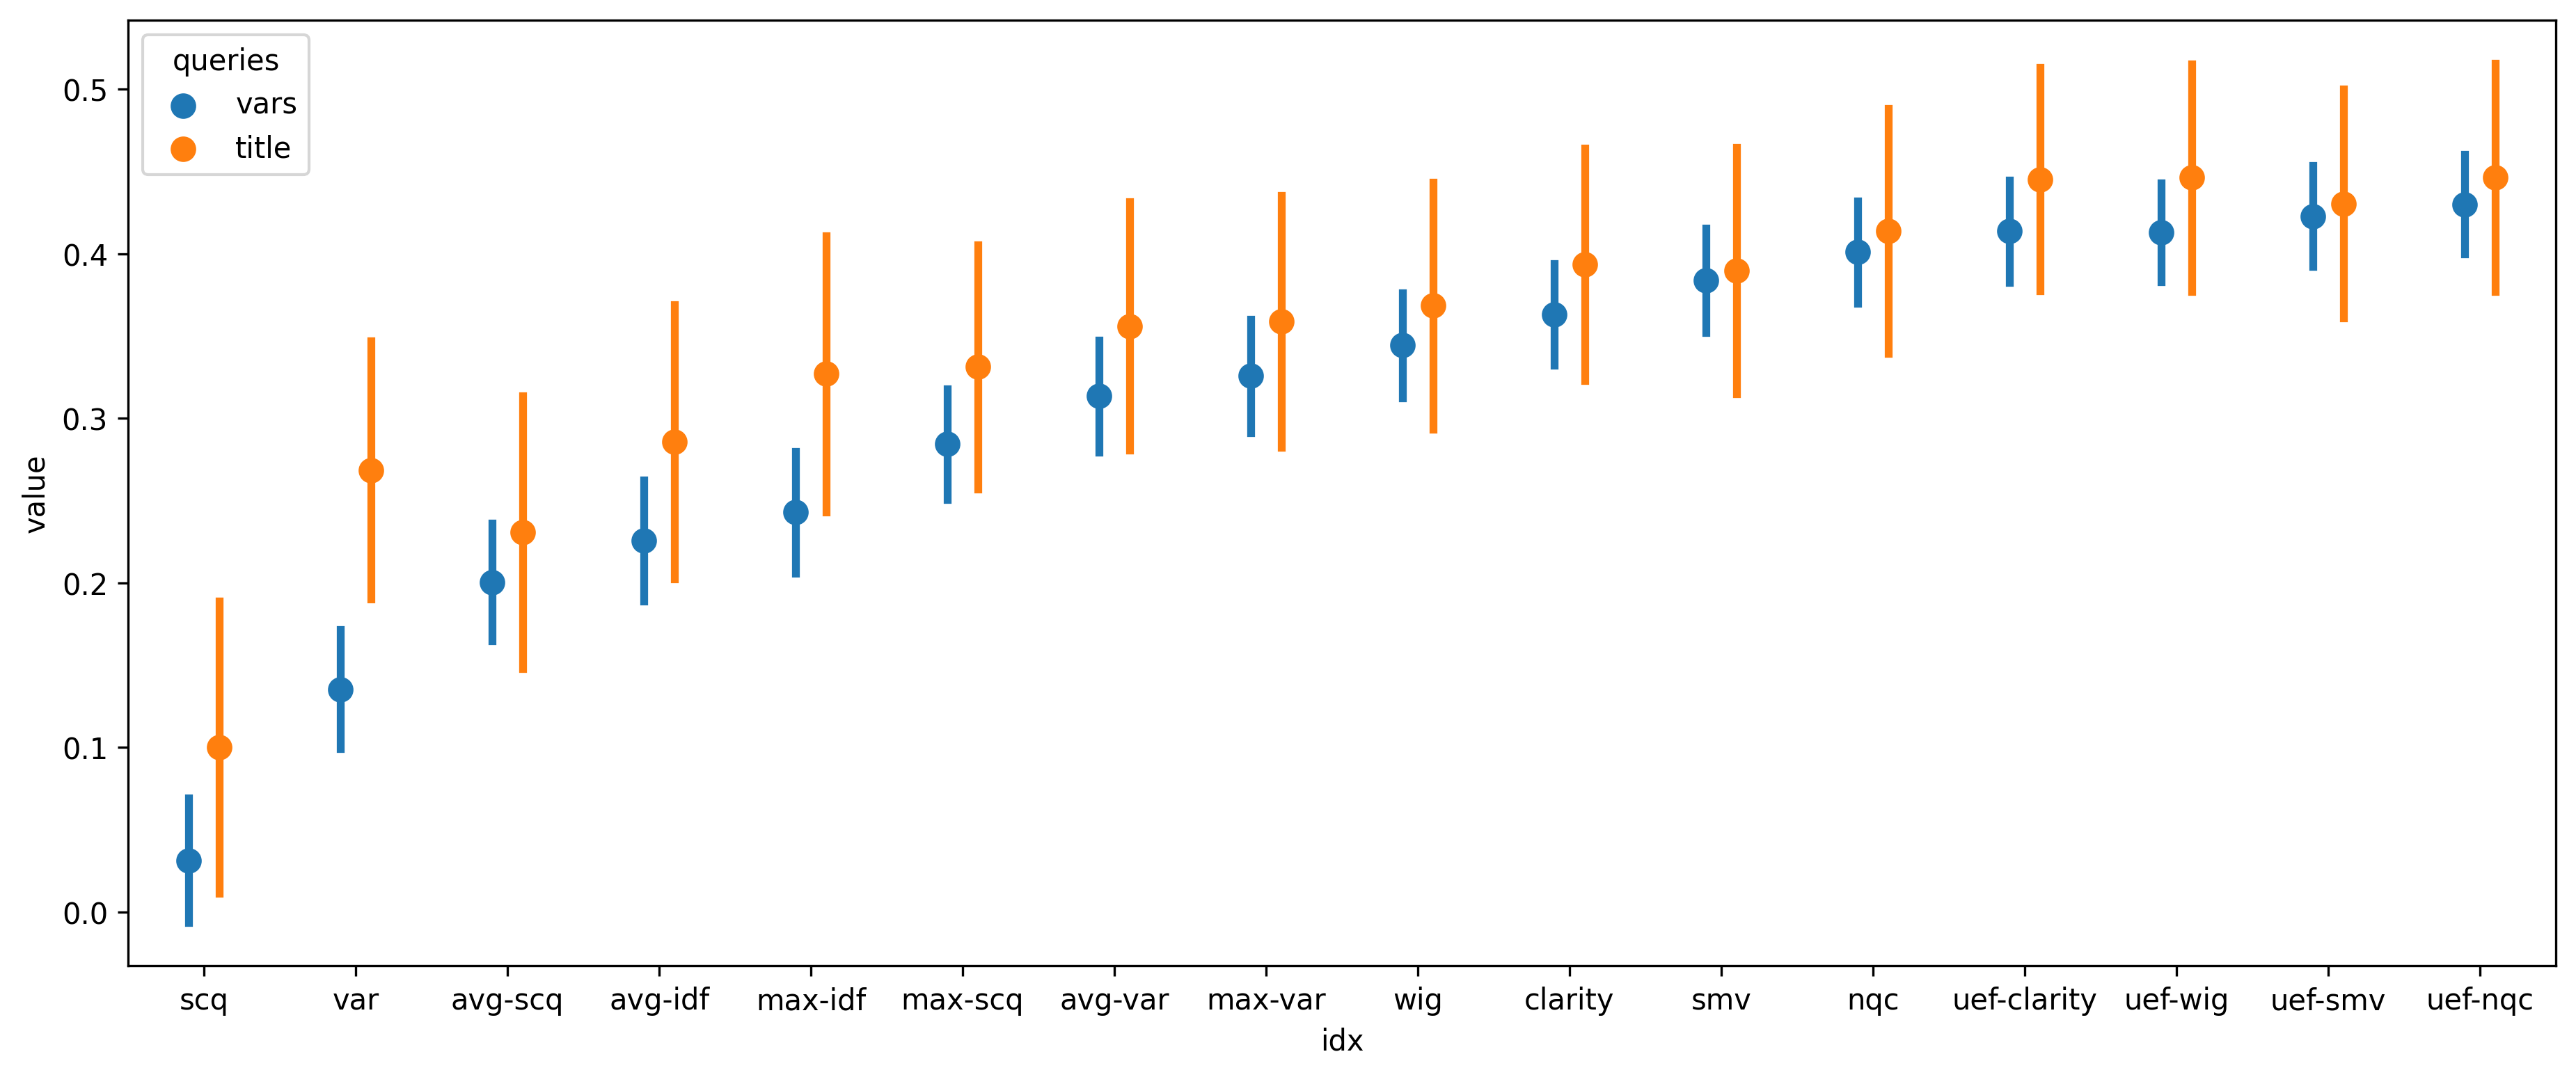

In [21]:
plt.figure(figsize=(15,6), dpi=300)
sns.pointplot(data=df,x=df.index,y='value', hue='queries',join=False, dodge=0.2, hue_order=['vars', 'title'], errorbar=("pi", 100))
plt.show()